In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.externals import joblib

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from PreprocessText import lemmatize_abstracts

import pyLDAvis
import umap
import hdbscan

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [2]:
abstracts = pd.read_pickle('data/EPMC/eye_in_new_keywords_ABSTRACTS_LEMMA.pkl')

pmids = abstracts.index
abstract_lengths = abstracts.str.split().str.len().values
abstracts.head()

pmid
30209082    ass prevalence cause vision impairment north a...
29781739    developed country genetically inherited eye di...
30092731    systemic autoimmune disease associated ocular ...
30096011    ass prevalence ocular manifestation related di...
30270476    optical coherence tomography oct provides non ...
Name: abstractText, dtype: object

In [3]:
countvec = joblib.load('models/sklearn/CountVec.joblib')
features = countvec.get_feature_names()

#countvec_vectors = countvec.transform(abstracts)
with open('data/EPMC/eye_in_new_keywords_ABSTRACTS_COUNTVEC.pkl','rb') as f:
    countvec_vectors = pickle.load(f)

term_frequency = countvec_vectors.sum(axis=0).tolist()[0]

del abstracts

print(countvec_vectors.shape)

(364989, 27509)


In [4]:
lda = joblib.load('models/sklearn/LDA_50topics_alleyekw.joblib') 
#lda = joblib.load('models/sklearn/LDA_ncomponents_100.joblib') 

topics = pd.DataFrame(lda.components_,columns=features)
print(topics.shape)

lda_vectors = lda.transform(countvec_vectors)
#with open('data/EPMC/eye_in_new_keywords_ABSTRACTS_LDAVEC.pkl','rb') as f:
#    lda_vectors = pickle.load(f)
    
print(lda_vectors.shape)

del countvec_vectors
#del lda

(50, 27509)
(364989, 50)


In [5]:
vis = pyLDAvis.prepare(topic_term_dists=lda.components_,
                       doc_topic_dists=lda_vectors,
                       doc_lengths=abstract_lengths,
                       vocab=features,
                       term_frequency=term_frequency,
                       mds='tsne',
                       sort_topics=False
                      )

pyLDAvis.display(vis)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [6]:
topics['photoreceptor'].sort_values(ascending=False)

23    16788.426411
33      276.467617
17        0.020000
49        0.020000
12        0.020000
21        0.020000
20        0.020000
19        0.020000
18        0.020000
16        0.020000
15        0.020000
14        0.020000
13        0.020000
11        0.020000
10        0.020000
9         0.020000
8         0.020000
7         0.020000
6         0.020000
5         0.020000
4         0.020000
3         0.020000
2         0.020000
1         0.020000
22        0.020000
24        0.020000
48        0.020000
25        0.020000
47        0.020000
46        0.020000
45        0.020000
44        0.020000
43        0.020000
42        0.020000
41        0.020000
40        0.020000
39        0.020000
38        0.020000
37        0.020000
36        0.020000
35        0.020000
34        0.020000
32        0.020000
31        0.020000
30        0.020000
29        0.020000
28        0.020000
27        0.020000
26        0.020000
0         0.020000
Name: photoreceptor, dtype: float64

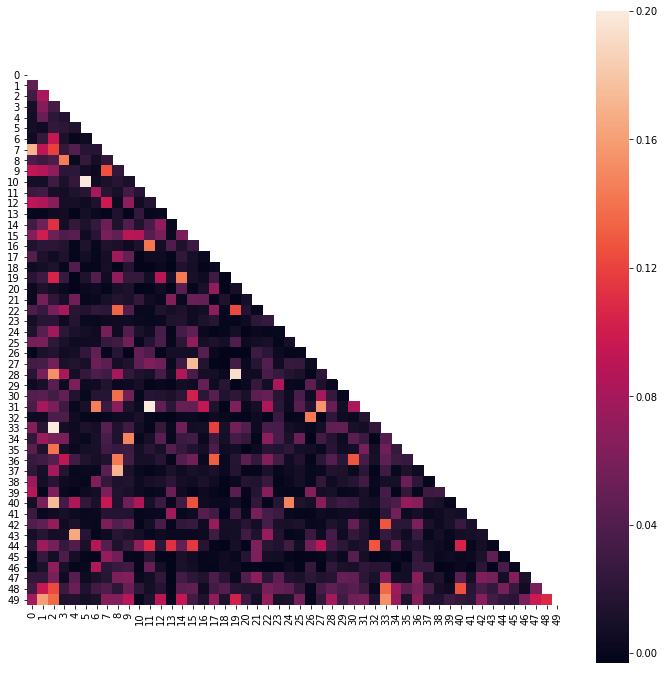

In [9]:
plt.figure(figsize=(12,12))
sns.heatmap(np.corrcoef(topics),vmax=0.2,square=True,mask=np.triu(np.ones([50,50])))

Text(0,0.5,'No. Publications')

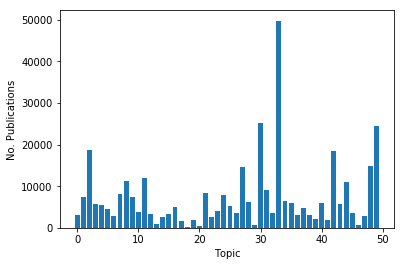

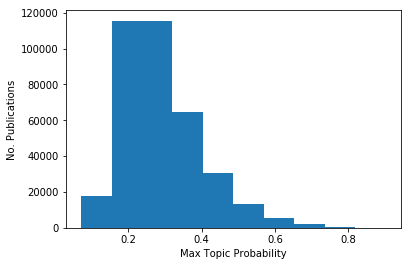

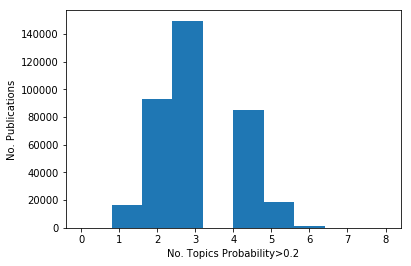

In [10]:
unique, counts = np.unique(lda_vectors.argmax(axis=1), return_counts=True)
plt.bar(unique,counts)
plt.xlabel('Topic')
plt.ylabel('No. Publications')

plt.figure()
plt.hist(lda_vectors.max(axis=1))
plt.xlabel('Max Topic Probability')
plt.ylabel('No. Publications')

plt.figure()
plt.hist((lda_vectors>0.1).sum(axis=1))
plt.xlabel('No. Topics Probability>0.2')
plt.ylabel('No. Publications')

([], <a list of 0 Text yticklabel objects>)

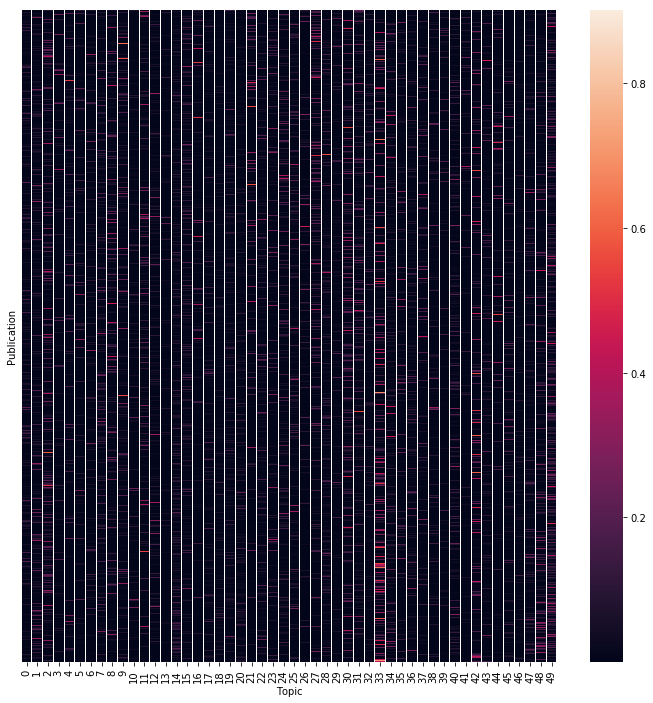

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(lda_vectors)
plt.xlabel('Topic')
plt.ylabel('Publication')
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

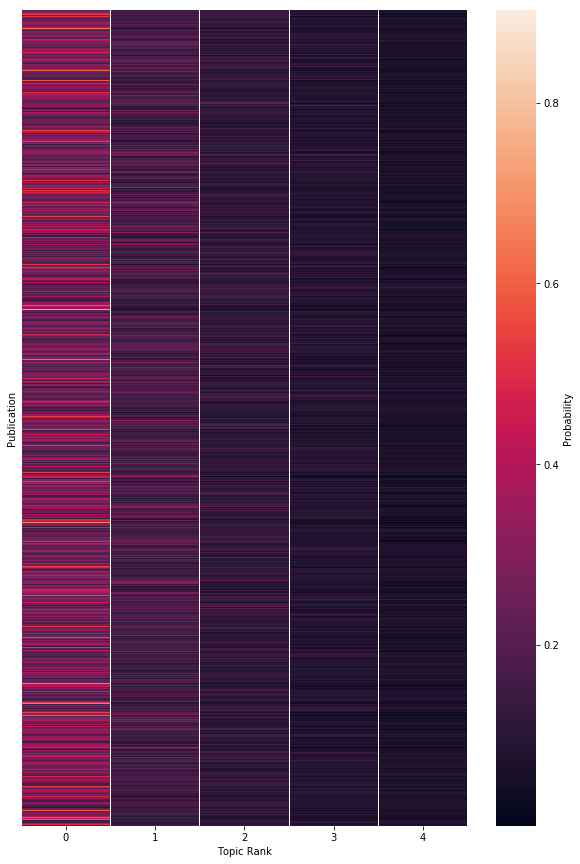

In [12]:
plt.figure(figsize=(10,15))
sns.heatmap((-np.sort(-lda_vectors,axis=1))[:,:5],
            cbar_kws={'label': 'Probability'})
plt.xlabel('Topic Rank')
plt.ylabel('Publication')
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

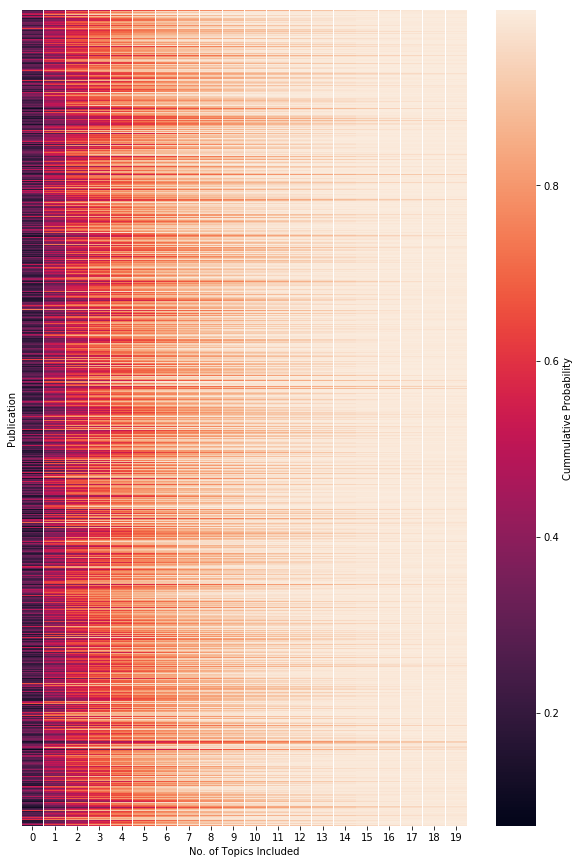

In [13]:
plt.figure(figsize=(10,15))
sns.heatmap(np.cumsum(-np.sort(-lda_vectors,axis=1),axis=1)[:,:20],
            cbar_kws={'label': 'Cummulative Probability'})
plt.xlabel('No. of Topics Included')
plt.ylabel('Publication')
plt.yticks([])

In [14]:
'''
#topic5
max_topic = lda_vectors.argmax(axis=1)
is_glaucoma = (lda_vectors/lda_vectors.mean(axis=0)).argmax(axis=1)==5
print(sum(is_glaucoma))
print(sum(df.loc[is_glaucoma,'citedByCount']))
'''

"\n#topic5\nmax_topic = lda_vectors.argmax(axis=1)\nis_glaucoma = (lda_vectors/lda_vectors.mean(axis=0)).argmax(axis=1)==5\nprint(sum(is_glaucoma))\nprint(sum(df.loc[is_glaucoma,'citedByCount']))\n"

In [15]:
'''
cited_bins = pd.cut(df.loc[is_glaucoma,'citedByCount'],[-0.5, 0.5, 3.5, 7.5, 17.5, 9999999], labels=['0','1 to 3','4 to 7','8 to 17','More than 17'])
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
ax = plt.figure(figsize=(10,5)).gca()
cited_bins.groupby(df['pubYear']).value_counts(normalize=False,sort=False).unstack(fill_value=0).plot.bar(stacked=True,ax=ax)
plt.ylabel('No. Publications')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(title='No. Citations')
'''

"\ncited_bins = pd.cut(df.loc[is_glaucoma,'citedByCount'],[-0.5, 0.5, 3.5, 7.5, 17.5, 9999999], labels=['0','1 to 3','4 to 7','8 to 17','More than 17'])\nimport matplotlib\nmatplotlib.rcParams.update({'font.size': 14})\nax = plt.figure(figsize=(10,5)).gca()\ncited_bins.groupby(df['pubYear']).value_counts(normalize=False,sort=False).unstack(fill_value=0).plot.bar(stacked=True,ax=ax)\nplt.ylabel('No. Publications')\nplt.xlabel('')\nplt.xticks(rotation=0)\nplt.legend(title='No. Citations')\n"

Text(0.5,1,'colour = topics')

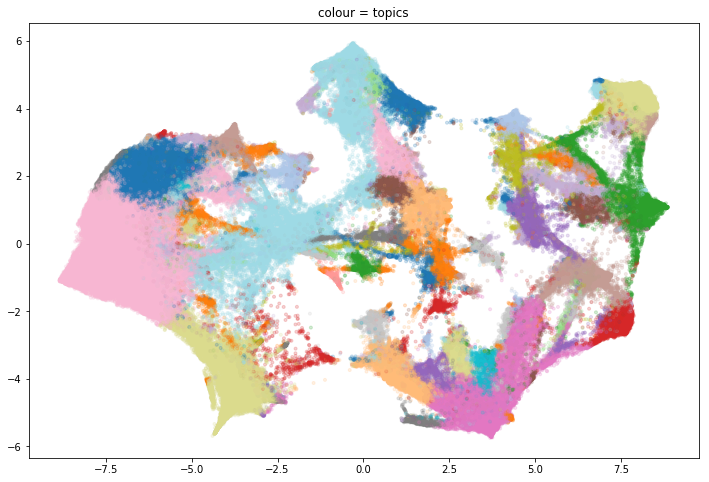

In [5]:
n_neighbors = 30 
metric = 'euclidean'
min_dist = 0

umapper = umap.UMAP(n_neighbors = n_neighbors, 
                    metric = metric, 
                    min_dist = min_dist)

X_umap = umapper.fit_transform(lda_vectors[lda_vectors.max(axis=1)>0.2])
#umap_base = 'models/umap/eyekws_LDA50_umap_neighbors_'
#umap_file = umap_base+str(n_neighbors)+'_metric_'+metric+'_dist_'+str(min_dist)+'.pkl'
#with open(umap_file,'wb') as f:
#    pickle.dump(umapper,f)

lda_topics = lda_vectors.argmax(axis=1)
colors = lda_topics[lda_vectors.max(axis=1)>0.2]

plt.figure(figsize=(12,8))
plt.scatter(X_umap[:,0],X_umap[:,1],marker='.',c=colors,alpha=0.2,cmap='tab20')
plt.title('colour = topics')

In [11]:
umap_base = 'models/umap/eyekws_LDA50_umap_neighbors_'
umap_file = umap_base+str(n_neighbors)+'_metric_'+metric+'_dist_'+str(min_dist)+'.pkl'
with open(umap_file,'wb') as f:
    pickle.dump(umapper,f)


In [10]:
#pmid, topic_vector
#pmid, max_topic, X_umap_0, X_umap_1

kw_umap = pd.DataFrame({'topic': lda_topics[lda_vectors.max(axis=1)>0.2],
                        'umap_x': X_umap[:,0],
                        'umap_y': X_umap[:,1]},
                       index=pmids[lda_vectors.max(axis=1)>0.2])

kw_umap.index.name = 'pmid'
kw_umap.to_pickle('models/umap/eyekws_datapoints.pkl')

kw_vectors = pd.DataFrame(lda_vectors[lda_vectors.max(axis=1)>0.2],
                          index=pmids[lda_vectors.max(axis=1)>0.2])

kw_vectors.index.name = 'pmid'
kw_vectors.to_pickle('models/sklearn/eyekws_vectors.pkl')
kw_vectors

0         1         2         3         4         5   \
pmid                                                                   
30209082  0.000124  0.012691  0.000124  0.000124  0.000124  0.015494   
29781739  0.009103  0.000116  0.000116  0.000116  0.000116  0.006356   
30092731  0.000230  0.000230  0.000230  0.000230  0.000230  0.000230   
30096011  0.029059  0.000202  0.000202  0.040048  0.000202  0.010804   
30270476  0.000114  0.036774  0.000114  0.059512  0.000114  0.007248   
29799159  0.000136  0.000136  0.019546  0.000136  0.000136  0.053447   
29545417  0.000120  0.000120  0.000120  0.000120  0.000120  0.006455   
29480270  0.000263  0.000263  0.000263  0.000263  0.000263  0.039340   
30240726  0.000103  0.000103  0.000103  0.000103  0.000103  0.000103   
30255821  0.000161  0.000161  0.000161  0.000161  0.000161  0.073789   
30127501  0.010020  0.000110  0.000110  0.000110  0.364250  0.018847   
29984333  0.000154  0.000154  0.000154  0.000154  0.012784  0.000154   
29747358  0.000106  0.000106  0.000106  0.000106  0.000106  0.000106   
30237818  0.023267  0.005780  0.000088  0.000088  0.000088  0.017837   
29846785  0.181717  0.000082  0.000082  0.113830  0.000082  0.000082   
27984353  0.000286  0.297360  0.000286  0.000286  0.000286  0.016096   
29856367  0.000157  0.004751  0.000157  0.000157  0.000157  0.000157   
30260717  0.000090  0.000090  0.000090  0.000090  0.017162  0.000090   
29135814  0.091605  0.046563  0.000108  0.000108  0.000108  0.000108   
28971364  0.061409  0.089910  0.000130  0.000130  0.000130  0.006698   
29716820  0.009768  0.005557  0.000080  0.000080  0.005158  0.000080   
30021046  0.000198  0.000198  0.000198  0.000198  0.044827  0.000198   
29926173  0.000120  0.000120  0.025716  0.000120  0.000120  0.013425   
30221735  0.000100  0.000100  0.000100  0.000100  0.000100  0.019127   
29166895  0.233600  0.000079  0.000079  0.000079  0.000079  0.010263   
30257375  0.000089  0.000089  0.000089  0.000089  0.000089  0.005111   
29057663  0.000132  0.000132  0.000132  0.000132  0.000132  0.000132   
29796434  0.000116  0.000116  0.000116  0.000116  0.000116  0.000116   
NaN       0.000118  0.000118  0.000118  0.000118  0.012350  0.012574   
30281641  0.013907  0.000062  0.000062  0.000062  0.000062  0.047740   
...            ...       ...       ...       ...       ...       ...   
10644767  0.000230  0.013493  0.000230  0.000230  0.104790  0.000230   
10611251  0.000202  0.000202  0.000202  0.000202  0.000202  0.011255   
10639175  0.000157  0.000157  0.000157  0.000157  0.000157  0.000157   
11163275  0.000267  0.019228  0.081944  0.000267  0.000267  0.000267   
10995752  0.000131  0.000131  0.232949  0.000131  0.000131  0.000131   
10954327  0.000153  0.000153  0.012206  0.000153  0.000153  0.000153   
10625580  0.000156  0.000156  0.305531  0.000156  0.000156  0.000156   
11069886  0.000308  0.000308  0.000308  0.000308  0.000308  0.000308   
11051549  0.000250  0.000250  0.042037  0.000250  0.013357  0.000250   
10985355  0.000241  0.019573  0.267423  0.000241  0.000241  0.000241   
12359725  0.000163  0.000163  0.065795  0.000163  0.000163  0.000163   
10862743  0.024383  0.000135  0.055204  0.000135  0.000135  0.000135   
10700251  0.000244  0.033666  0.147571  0.000244  0.068994  0.000244   
10699977  0.000192  0.000192  0.233583  0.000192  0.037739  0.056023   
12429924  0.000183  0.000183  0.099178  0.000183  0.000183  0.000183   
11103947  0.000308  0.000308  0.018836  0.000308  0.000308  0.070965   
10654602  0.000165  0.033084  0.055617  0.000165  0.000165  0.000165   
28609084  0.000364  0.040268  0.000364  0.000364  0.000364  0.061068   
10914935  0.034615  0.000104  0.006752  0.000104  0.008039  0.000104   
11913975  0.000250  0.000250  0.338561  0.000250  0.000250  0.000250   
11593423  0.044168  0.000198  0.118677  0.000198  0.000198  0.000198   
11598125  0.009470  0.000154  0.212150  0.000154  0.000154  0.000154   
11784000  0.000175  0.000175  0.045733  0.000175  0.0001

In [3]:
import pandas as pd

kw_umap = pd.read_pickle('models/umap/eyekws_datapoints.pkl')
kw_vectors = pd.read_pickle('models/sklearn/eyekws_vectors.pkl')

df = pd.read_pickle('/project/fight-for-sight/data/EPMC/eye_in_new_keywords.pkl')
df.set_index('pmid',inplace=True)
df.head()
df['firstPublicationDate'] = pd.to_datetime(df['firstPublicationDate'])
pubYear = df['firstPublicationDate'].dt.year.astype(int)
pubYear.name = 'pubYear'
del df

In [17]:
pubYear.name = 'pubYear'
pubYear

pmid
30209082    2018
29781739    2018
30092731    2018
30096011    2018
30270476    2018
29799159    2018
29545417    2018
29859105    2018
29480270    2018
30240726    2018
30255821    2018
30127501    2018
29984333    2018
29747358    2018
30237818    2018
29846785    2018
27984353    2018
29856367    2018
30260717    2018
29135814    2018
28971364    2017
29716820    2018
30021046    2018
29926173    2018
30221735    2018
29166895    2017
30257375    2018
29057663    2017
29796434    2018
NaN         2018
            ... 
12359725    2002
10862743    2000
10882819    2000
10700251    2000
10699977    2000
10736742    2000
10736739    2000
12429924    2002
11103947    2000
10654602    2000
28609084    2015
10736744    2000
10914935    2000
11913975    2002
11593423    2001
11598125    2001
11784000    2001
11494151    2001
11749040    2001
23669186    2013
10982823    2000
11146548    2000
11062467    2000
10942587    2000
10938405    2000
10799750    2000
16111433    2005
12709292 

In [18]:
kw_umap[kw_umap.index.notna()].join(pubYear,how='left').to_pickle('models/umap/eyekws_datapoints.pkl')
kw_vectors[kw_umap.index.notna()].join(pubYear,how='left').to_pickle('models/sklearn/eyekws_vectors.pkl')

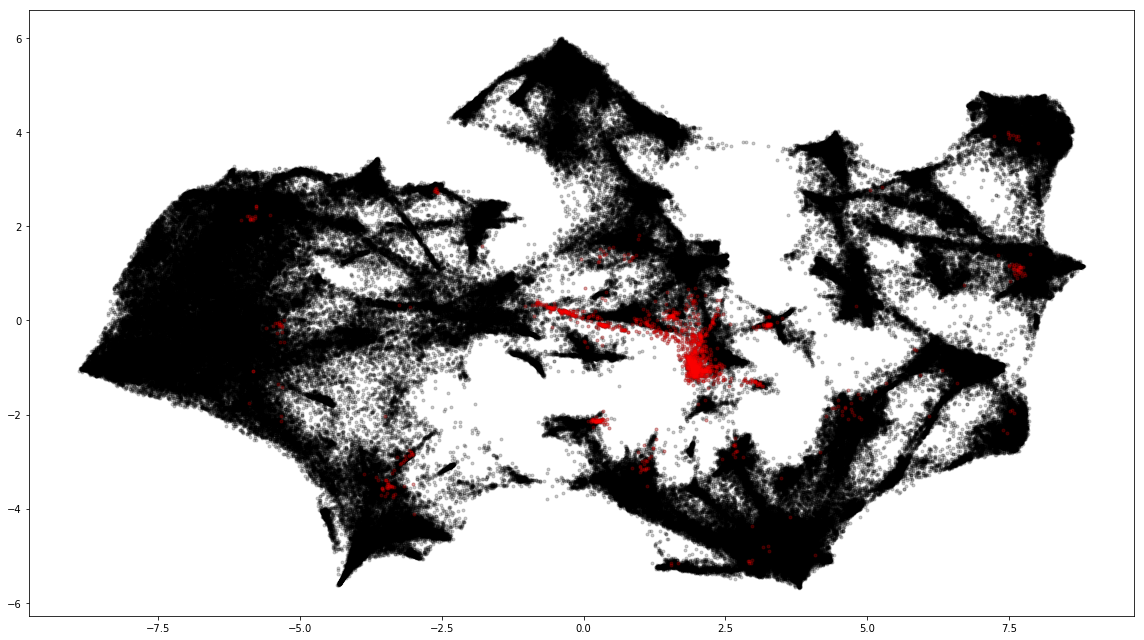

In [27]:
#X_umap[]
X_umap[lda_topics[lda_vectors.max(axis=1)>0.2]==42].mean(axis=0)

plt.figure(figsize=(16,9))
plt.scatter(X_umap[:,0],X_umap[:,1],
            marker='.',alpha=0.2,cmap='hsv',
            c='k')

plt.scatter(X_umap[lda_topics[lda_vectors.max(axis=1)>0.2]==0, 0],
            X_umap[lda_topics[lda_vectors.max(axis=1)>0.2]==0, 1],
            marker='.',alpha=0.2,cmap='hsv',
            c='r')

#plt.title('colour = topics')
#plt.axis('off')
plt.tight_layout()
#plt.savefig('plots/umap/eyekw.png',dpi=300)

In [22]:
topics['retinoblastoma'].sort_values(ascending=False)

0     15202.021489
12        0.020000
22        0.020000
21        0.020000
20        0.020000
19        0.020000
18        0.020000
17        0.020000
16        0.020000
15        0.020000
14        0.020000
13        0.020000
11        0.020000
48        0.020000
10        0.020000
9         0.020000
8         0.020000
7         0.020000
6         0.020000
5         0.020000
4         0.020000
3         0.020000
2         0.020000
1         0.020000
23        0.020000
49        0.020000
25        0.020000
26        0.020000
47        0.020000
46        0.020000
45        0.020000
44        0.020000
43        0.020000
42        0.020000
41        0.020000
40        0.020000
39        0.020000
38        0.020000
37        0.020000
36        0.020000
35        0.020000
34        0.020000
33        0.020000
32        0.020000
31        0.020000
30        0.020000
29        0.020000
28        0.020000
27        0.020000
24        0.020000
Name: retinoblastoma, dtype: float64

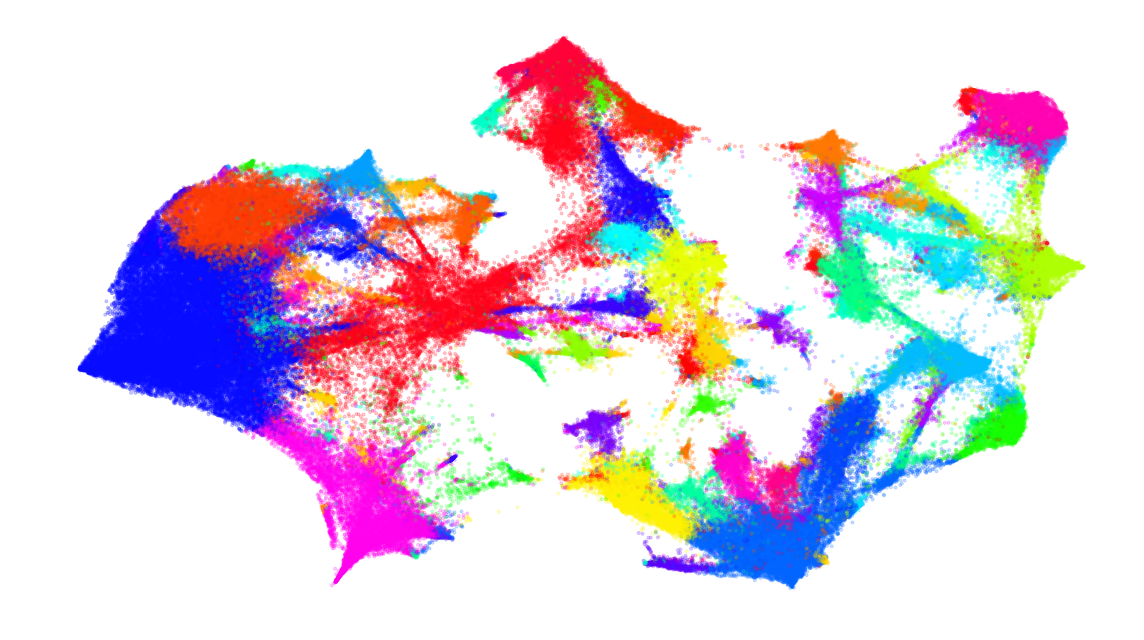

In [6]:
plt.figure(figsize=(16,9))
plt.scatter(X_umap[:,0],X_umap[:,1],
            marker='.',alpha=0.2,cmap='hsv',
            c=lda_topics[lda_vectors.max(axis=1)>0.2])
#plt.title('colour = topics')
plt.axis('off')
plt.tight_layout()
plt.savefig('plots/umap/eyekw.png',dpi=300)

In [ ]:
min_cluster_size = 15
min_samples = 1
cluster_selection_method = 'eom'

clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                            min_samples = min_samples,
                            cluster_selection_method = cluster_selection_method,
                            core_dist_n_jobs=-1)

clusters = clusterer.fit_predict(lda_vectors)

hdb_base = 'models/hdbscan/eyekws_LDA50_hdbscan_clustersize_'
hdb_file = hdb_base+str(min_cluster_size)+'_minsamples_'+str(min_samples)+'_method_'+cluster_selection_method+'.pkl'
with open(hdb_file,'wb') as f:
    pickle.dump(clusterer,f)

print('No. clusters:',len(np.unique(clusters)))

plt.figure(figsize=(12,8))
plt.scatter(X_umap[clusters==-1,0], X_umap[clusters==-1,1], c='k', marker='x', alpha=0.1)
plt.scatter(X_umap[clusters>-1,0], X_umap[clusters>-1,1], 
            c=clusters[clusters>-1], cmap='tab20',alpha=1,marker='.')

In [ ]:
unique,counts = np.unique(clusters,return_counts=True)
sum(counts[1:])

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(X_umap[clusters>-1,0], X_umap[clusters>-1,1], 
            c=clusters[clusters>-1], cmap='tab20',alpha=1,marker='.')

In [ ]:
plt.hist(lda_vectors.max(axis=1))

In [ ]:
tmp=lda_vectors#[lda_vectors.max(axis=1)>0.2]

umapper = umap.UMAP(n_neighbors=15, 
                    n_components=2, 
                    metric='euclidean', 
                    min_dist=0)

X_umap = umapper.fit_transform(tmp)

plt.figure(figsize=(12,8))
plt.scatter(X_umap[:,0],X_umap[:,1],marker='.',alpha=0.5)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15,
                            min_samples=1,
                            cluster_selection_method='leaf',
                            core_dist_n_jobs=-1)

clusters = clusterer.fit_predict(tmp)
#clusters = clusterer.fit_predict(X_umap)

print('No. clusters:',len(np.unique(clusters)))

plt.figure(figsize=(12,8))
plt.scatter(X_umap[clusters==-1,0], X_umap[clusters==-1,1], c='k', marker='x', alpha=0.1)
plt.scatter(X_umap[clusters>-1,0], X_umap[clusters>-1,1], 
            c=clusters[clusters>-1], cmap='tab20',alpha=1,marker='.')

In [ ]:
tmp=lda_vectors#[lda_vectors.max(axis=1)>0.2]
c = tmp.argmax(axis=1)

umapper = umap.UMAP(n_neighbors=15, 
                    n_components=2, 
                    metric='euclidean', 
                    min_dist=0)

X_umap = umapper.fit_transform(tmp)

plt.figure(figsize=(12,8))
plt.scatter(X_umap[:,0],X_umap[:,1],marker='.',alpha=0.5,c=c,cmap='tab20')


In [ ]:
for c in np.unique(clusters[clusters>-1]):
    print('---------------------------')
    print('CLUSTER',c)
    print('---------------------------')
    sum_lda = np.mean(lda_vectors[clusters==c,:],axis=0)
    print(pd.Series(sum_lda).sort_values(ascending=False).head())
    
    print('UMAP_0 =',np.mean(X_umap[clusters==c,0]))
    print('UMAP_1 =',np.mean(X_umap[clusters==c,1]))

In [ ]:
topics.iloc[42].sort_values(ascending=False).head(20)


In [ ]:
abstracts[clusters==0]

## Where do FFS papers fit in?

In [20]:
print('loading data')
df = pd.read_pickle('data/EPMC/ffs_or_predecessors.pkl')
df.drop_duplicates(subset='pmid',inplace=True)
df.set_index('pmid',inplace=True)
print(len(df),'rows')

ffs_abstracts = df.loc[~df['abstractText'].isnull(),'abstractText']

del df

print('lemmatising')
ffs = lemmatize_abstracts(ffs_abstracts)

pmids = ffs_abstracts.index
ffs_abstracts.head()

print('counting')
ffs_counts = countvec.transform(ffs_abstracts)

print('lda')
ffs_lda_vectors = lda.transform(ffs_counts)

print('umap')
ffs_umap = umapper.transform(ffs_lda_vectors)

loading data
1564 rows
lemmatising
Removing missing abstracts
Initial preprocessing: case, punctuation, whitespace
Lemmatizing
counting
lda
umap


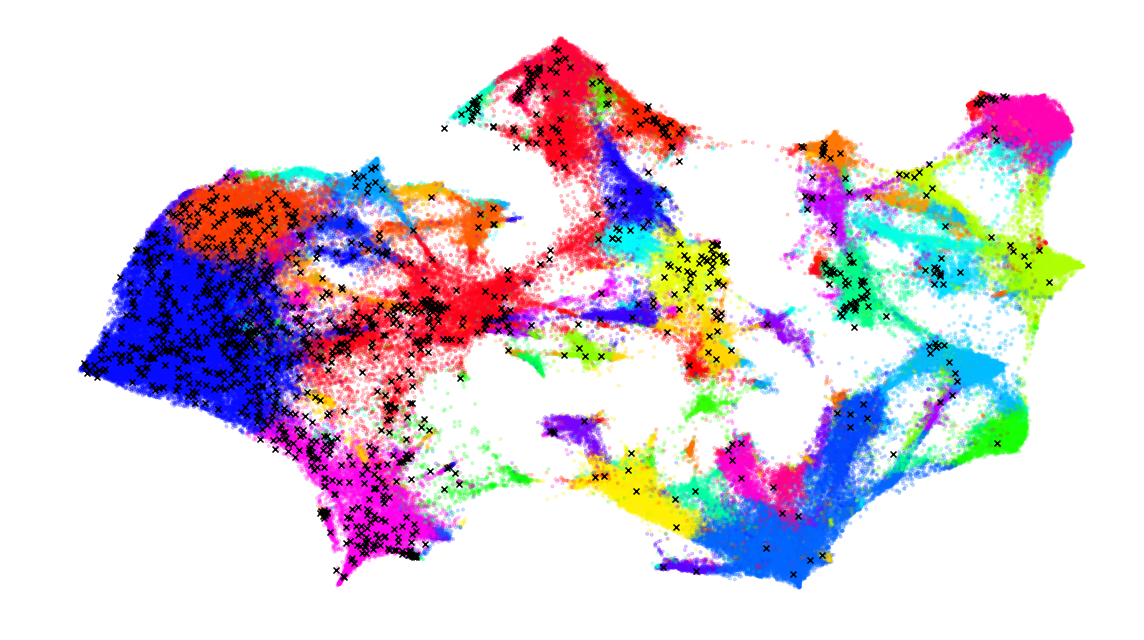

In [21]:
plt.figure(figsize=(16,9))
plt.scatter(X_umap[:,0],X_umap[:,1],
            marker='.',alpha=0.2,cmap='hsv',
            c=lda_topics[lda_vectors.max(axis=1)>0.2])

plt.scatter(ffs_umap[ffs_lda_vectors.max(axis=1)>0.2,0],ffs_umap[ffs_lda_vectors.max(axis=1)>0.2,1],marker='x',alpha=1,c='k')

plt.axis('off')
plt.tight_layout()
plt.savefig('plots/umap/eyekw_and_ffs.png',dpi=300)

In [ ]:
ffs_topic_mean = ffs_lda_vectors.mean(axis=0)
eyekw_topic_mean = lda_vectors.mean(axis=0)
mean_topics = pd.DataFrame({'eye kws':eyekw_topic_mean, 'ffs':ffs_topic_mean})
mean_topics.index.name = 'Topic'

ax = plt.figure(figsize=(15,5)).gca()
mean_topics.plot.bar(ax=ax)

mean_topics['diff'] = mean_topics['ffs']-mean_topics['eye kws']
ax = plt.figure(figsize=(15,5)).gca()
mean_topics['diff'].plot.bar(ax=ax)

In [ ]:
topics.iloc[33].sort_values(ascending=False).head(20)


## citations

In [ ]:
print('loading data')
df = pd.read_pickle('data/EPMC/ffs_or_predecessors_citations.pkl')
df.drop_duplicates(subset='pmid',inplace=True)
df.set_index('pmid',inplace=True)
print(len(df),'rows')

cited_abstracts = df.loc[~df['abstractText'].isnull(),'abstractText']

del df

print('lemmatising')
cited = lemmatize_abstracts(cited_abstracts)

pmids = cited_abstracts.index
cited_abstracts.head()

print('counting')
cited_counts = countvec.transform(cited_abstracts)

print('lda')
cited_lda_vectors = lda.transform(cited_counts)

print('umap')
cited_umap = umapper.transform(cited_lda_vectors)

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(X_umap[:,0],X_umap[:,1],marker='.',alpha=0.01,c='k')
plt.scatter(cited_umap[:,0],cited_umap[:,1],marker='.',alpha=0.5,c='b')
plt.scatter(ffs_umap[:,0],ffs_umap[:,1],marker='.',alpha=1,c='r')


In [ ]:
ffs_topic_mean = ffs_lda_vectors.mean(axis=0)
cited_topic_mean = cited_lda_vectors.mean(axis=0)
eyekw_topic_mean = lda_vectors.mean(axis=0)
mean_topics = pd.DataFrame({'eye kws':eyekw_topic_mean, 'ffs':ffs_topic_mean,'cited':cited_topic_mean})
mean_topics.index.name = 'Topic'

ax = plt.figure(figsize=(15,5)).gca()
mean_topics.plot.bar(ax=ax)

In [ ]:
from wordcloud import WordCloud
from sklearn.externals import joblib
import pandas as pd
import matplotlib.pyplot as plt

countvec = joblib.load('data/CountVec.joblib')
features = countvec.get_feature_names()

lda = joblib.load('data/LDA_50topics_alleyekw.joblib') 
topics = pd.DataFrame(lda.components_,columns=features)


In [ ]:
for i in range(len(topics)):
    text = topics.iloc[i].sort_values(ascending=False).to_dict()

    # Generate a word cloud image
    wordcloud = WordCloud().generate_from_frequencies(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('TOPIC '+str(i))
    plt.show()
    # lower max_font_size
    #wordcloud = WordCloud(max_font_size=40).generate(text)
    #plt.figure()
    #plt.imshow(wordcloud, interpolation="bilinear")
    #plt.axis("off")
    #plt.show()